In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## load data

In [2]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## detect GPU

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


## Early stop module

In [4]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

early_stopping = EarlyStopping(tolerance=10, min_delta=.2)


## show some samples

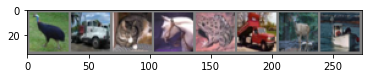

tensor([2, 9, 3, 7, 6, 9, 4, 8])
bird  truck cat   horse frog  truck deer  ship 


In [18]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))
print(labels[:8])
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## neural network 
> using simple LeNet as classifier

> improving our LeNet to get better accuarcy

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


CNN = CNN()
CNN.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.001)

In [ ]:
epochs = 30
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = CNN(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0
train loss:1.3145681781232204
validation loss:1.329903608636011
Accuracy of the network on the 10000 test images: 52 %
epoch: 1
train loss:1.3121253855697943
validation loss:1.3245734112172187
Accuracy of the network on the 10000 test images: 52 %
epoch: 2
train loss:1.3093847682713853
validation loss:1.3351511668555345
Accuracy of the network on the 10000 test images: 51 %
epoch: 3
train loss:1.3073695367559448
validation loss:1.3393543973753723
Accuracy of the network on the 10000 test images: 51 %
epoch: 4
train loss:1.3055771058782593
validation loss:1.3260962993283816
Accuracy of the network on the 10000 test images: 51 %
epoch: 5
train loss:1.3038744819743553
validation loss:1.3280031152918368
Accuracy of the network on the 10000 test images: 52 %
epoch: 6
train loss:1.3022086248373437
validation loss:1.3181646111645275
Accuracy of the network on the 10000 test images: 52 %
epoch: 7
train loss:1.2988541486013272
validation loss:1.3124727176714548
Accuracy of the network 

### show some test set images and predicted values

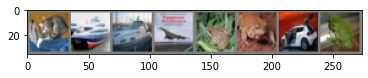

GroundTruth:  cat   ship  ship  plane frog  frog  automobile frog 
Predicted:  horse cat   ship  ship  ship  deer  horse truck


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

### more evaluation on model 
> total accuracy

> accuracy per class

> confusion matrix

In [ ]:
correct = 0
total = 0
predicts = list()
all_labels = list()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = CNN(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicts.extend(predicted)
        all_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = CNN(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.6 %
Accuracy for class: automobile is 60.7 %
Accuracy for class: bird  is 35.9 %
Accuracy for class: cat   is 41.7 %
Accuracy for class: deer  is 35.7 %
Accuracy for class: dog   is 41.0 %
Accuracy for class: frog  is 70.8 %
Accuracy for class: horse is 63.9 %
Accuracy for class: ship  is 62.7 %
Accuracy for class: truck is 62.8 %


In [ ]:
predicts = [i.item() for i in predicts]
all_labels = [i.item() for i in all_labels]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predicts, all_labels)

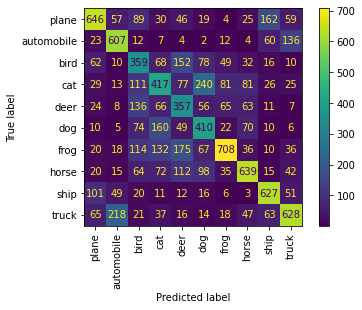

In [ ]:
ConfusionMatrixDisplay.from_predictions(predicts, all_labels, display_labels=classes, xticks_rotation='vertical')

In [ ]:
import gc 

del CNN 
gc.collect()

698

In [ ]:
gc.collect()

44

### add batch normalization layer to LeNet and see its effect

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.batch_norm = nn.BatchNorm2d(3, 32, 32)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


CNN = CNN()
CNN.to(device)

CNN(
  (batch_norm): BatchNorm2d(3, eps=32, momentum=32, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=10, min_delta=.2)


In [ ]:
epochs = 100
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = CNN(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0
train loss:2.305266949221911
validation loss:2.3050903670395475
Accuracy of the network on the 10000 test images: 10 %
epoch: 1
train loss:2.3049861305509993
validation loss:2.3048133276685885
Accuracy of the network on the 10000 test images: 10 %
epoch: 2
train loss:2.3047310684038247
validation loss:2.3045643100255653
Accuracy of the network on the 10000 test images: 10 %
epoch: 3
train loss:2.304506726886915
validation loss:2.304339493377299
Accuracy of the network on the 10000 test images: 10 %
epoch: 4
train loss:2.304281691456085
validation loss:2.3041371544705163
Accuracy of the network on the 10000 test images: 10 %
epoch: 5
train loss:2.304095229834242
validation loss:2.3039530379862727
Accuracy of the network on the 10000 test images: 10 %
epoch: 6
train loss:2.303912042656823
validation loss:2.303786914559859
Accuracy of the network on the 10000 test images: 10 %
epoch: 7
train loss:2.303753107709958
validation loss:2.3036350207992746
Accuracy of the network on the 

### Working on LeNet hyper-parameters to get a better accuracy

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


CNN = CNN()
CNN.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.01, momentum=0.9)
early_stopping = EarlyStopping(tolerance=10, min_delta=.2)


In [ ]:
epochs = 100
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = CNN(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0
train loss:2.0647619822446037
validation loss:1.6727342741398872
Accuracy of the network on the 10000 test images: 39 %
epoch: 1
train loss:1.5589318854729537
validation loss:1.450678682025475
Accuracy of the network on the 10000 test images: 47 %
epoch: 2
train loss:1.3695719534783717
validation loss:1.3046707005440434
Accuracy of the network on the 10000 test images: 52 %
epoch: 3
train loss:1.2501016349133933
validation loss:1.2417129776145839
Accuracy of the network on the 10000 test images: 55 %
epoch: 4
train loss:1.167440563059219
validation loss:1.1924118603332132
Accuracy of the network on the 10000 test images: 57 %
epoch: 5
train loss:1.093343328789372
validation loss:1.1807930884481985
Accuracy of the network on the 10000 test images: 58 %
epoch: 6
train loss:1.036315898456232
validation loss:1.1112053515035896
Accuracy of the network on the 10000 test images: 60 %
epoch: 7
train loss:0.9879109202443487
validation loss:1.0888329412363753
Accuracy of the network on 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.pool(F.relu(self.conv6(F.relu(self.conv5(x)))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


CNN = CNN()
CNN.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.01)
early_stopping = EarlyStopping(tolerance=10, min_delta=.2)

In [ ]:
epochs = 100
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = CNN(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0
train loss:2.3030555528752945
validation loss:2.302761313281482
Accuracy of the network on the 10000 test images: 10 %
epoch: 1
train loss:2.3027488538981093
validation loss:2.302601343468775
Accuracy of the network on the 10000 test images: 10 %
epoch: 2
train loss:2.302625151241527
validation loss:2.302530499953258
Accuracy of the network on the 10000 test images: 10 %
epoch: 3
train loss:2.3025691570223445
validation loss:2.302493035038815
Accuracy of the network on the 10000 test images: 10 %
epoch: 4
train loss:2.3025402955691834
validation loss:2.3024740098397944
Accuracy of the network on the 10000 test images: 11 %
epoch: 5
train loss:2.3025171390884673
validation loss:2.3024510522431965
Accuracy of the network on the 10000 test images: 10 %
epoch: 6
train loss:2.3024892630174643
validation loss:2.302427623845354
Accuracy of the network on the 10000 test images: 10 %
epoch: 7
train loss:2.3024629278256157
validation loss:2.302398090121112
Accuracy of the network on the

### add drop out to prevent model from overfit

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout1 = nn.Dropout2d(p=0.05)
        self.dropout2 = nn.Dropout2d(p=0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv6(F.relu(self.conv5(x)))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


CNN = CNN()
CNN.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout1): Dropout2d(p=0.05, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.01)
early_stopping = EarlyStopping(tolerance=10, min_delta=.2)

In [ ]:
epochs = 100
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = CNN(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


train loss:2.3027310536035794
validation loss:2.3026375921466684
Accuracy of the network on the 10000 test images: 9 %
epoch: 1
train loss:2.3026149840001255
validation loss:2.3025534605678124
Accuracy of the network on the 10000 test images: 10 %
epoch: 2
train loss:2.302550131707545
validation loss:2.3024555671064157
Accuracy of the network on the 10000 test images: 10 %
epoch: 3
train loss:2.3025064614727673
validation loss:2.3025033383429805
Accuracy of the network on the 10000 test images: 10 %
epoch: 4
train loss:2.3024218954393625
validation loss:2.302352525010894
Accuracy of the network on the 10000 test images: 11 %
epoch: 5
train loss:2.302382247222354
validation loss:2.302261609065382
Accuracy of the network on the 10000 test images: 11 %
epoch: 6
train loss:2.3022843980423326
validation loss:2.3021861299683777
Accuracy of the network on the 10000 test images: 13 %
epoch: 7
train loss:2.302167740624274
validation loss:2.3020055112959463
Accuracy of the network on the 10000 t

### lowering learning rate to help convergance of the model 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout1 = nn.Dropout2d(p=0.05)
        self.dropout2 = nn.Dropout2d(p=0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv6(F.relu(self.conv5(x)))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


CNN = CNN()
CNN.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout1): Dropout2d(p=0.05, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=10, min_delta=1)

In [ ]:
epochs = 100
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = CNN(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0
train loss:2.3030422178985517
validation loss:2.3028789200360262
Accuracy of the network on the 10000 test images: 10 %
epoch: 1
train loss:2.302990259111995
validation loss:2.3028398706943176
Accuracy of the network on the 10000 test images: 10 %
epoch: 2
train loss:2.3029584433416574
validation loss:2.302827213383928
Accuracy of the network on the 10000 test images: 10 %
epoch: 3
train loss:2.3029154597036063
validation loss:2.302799490433705
Accuracy of the network on the 10000 test images: 10 %
epoch: 4
train loss:2.302889659276704
validation loss:2.3027527483203745
Accuracy of the network on the 10000 test images: 9 %
epoch: 5
train loss:2.3028647716697828
validation loss:2.3027000185809556
Accuracy of the network on the 10000 test images: 10 %
epoch: 6
train loss:2.3028181830940344
validation loss:2.302753013900564
Accuracy of the network on the 10000 test images: 10 %
epoch: 7
train loss:2.302774040900228
validation loss:2.3026321447348295
Accuracy of the network on the

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout1 = nn.Dropout2d(p=0.05)
        self.dropout2 = nn.Dropout2d(p=0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv6(F.relu(self.conv5(x)))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


CNN = CNN()
CNN.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout1): Dropout2d(p=0.05, inplace=False)
  (dropout2): Dropout2d(p=0.1, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.001, momentum=0.8)
early_stopping = EarlyStopping(tolerance=10, min_delta=1)

In [ ]:
epochs = 100
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = CNN(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


train loss:2.302845842088275
validation loss:2.302821011482915
Accuracy of the network on the 10000 test images: 10 %
epoch: 1
train loss:2.3027416982919053
validation loss:2.3026766565781607
Accuracy of the network on the 10000 test images: 10 %
epoch: 2
train loss:2.302635400191597
validation loss:2.302609911447839
Accuracy of the network on the 10000 test images: 9 %
epoch: 3
train loss:2.3025952983085456
validation loss:2.302559396888636
Accuracy of the network on the 10000 test images: 10 %
epoch: 4
train loss:2.302543682820352
validation loss:2.3025386635261245
Accuracy of the network on the 10000 test images: 10 %
epoch: 5
train loss:2.3025001052700347
validation loss:2.302482342418236
Accuracy of the network on the 10000 test images: 10 %
epoch: 6
train loss:2.302492970395881
validation loss:2.3025107926960233
Accuracy of the network on the 10000 test images: 10 %
epoch: 7
train loss:2.3024707450281325
validation loss:2.3024182168743277
Accuracy of the network on the 10000 test

## using more complex networks such as vgg16 to solve our task

### VGG16

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

CNN = VGG('VGG16')
CNN.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.01, weight_decay = 5e-4, momentum = 0.9)
early_stopping = EarlyStopping(tolerance=5, min_delta=.5)

In [ ]:
epochs = 100
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = CNN(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0
train loss:1.3309280140625546
validation loss:0.997264788875097
Accuracy of the network on the 10000 test images: 65 %
epoch: 1
train loss:0.7809878452812009
validation loss:0.7163549058045013
Accuracy of the network on the 10000 test images: 75 %
epoch: 2
train loss:0.5745740095367822
validation loss:0.6079342580294307
Accuracy of the network on the 10000 test images: 79 %
epoch: 3
train loss:0.45287095227509816
validation loss:0.563266643240482
Accuracy of the network on the 10000 test images: 81 %
epoch: 4
train loss:0.36016142951405566
validation loss:0.5627511932125574
Accuracy of the network on the 10000 test images: 81 %
epoch: 5
train loss:0.284323502760714
validation loss:0.537666380405426
Accuracy of the network on the 10000 test images: 82 %
epoch: 6
train loss:0.2226491350766338
validation loss:0.5706619971160647
Accuracy of the network on the 10000 test images: 83 %
epoch: 7
train loss:0.18186677002426607
validation loss:0.5595800882276101
Accuracy of the network 

### ResNet

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


ResNet18 = ResNet(BasicBlock, [2, 2, 2, 2])
ResNet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18.parameters(), lr=0.01, weight_decay = 5e-4, momentum = 0.9)
early_stopping = EarlyStopping(tolerance=5, min_delta=.5)

In [ ]:
epochs = 100
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = ResNet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = ResNet18(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0
train loss:1.2569347020915098
validation loss:0.8679762897612173
Accuracy of the network on the 10000 test images: 69 %
epoch: 1
train loss:0.7321185870548649
validation loss:0.6843921813783767
Accuracy of the network on the 10000 test images: 76 %
epoch: 2
train loss:0.5200260771662378
validation loss:0.6034167454212527
Accuracy of the network on the 10000 test images: 79 %
epoch: 3
train loss:0.37209346562700196
validation loss:0.6005931937996345
Accuracy of the network on the 10000 test images: 79 %
epoch: 4
train loss:0.25631189127178755
validation loss:0.6459373062170004
Accuracy of the network on the 10000 test images: 79 %
epoch: 5
train loss:0.17520086743566385
validation loss:0.6782771005660673
Accuracy of the network on the 10000 test images: 80 %
epoch: 6
train loss:0.11756871051400367
validation loss:0.6954752384107324
Accuracy of the network on the 10000 test images: 81 %
epoch: 7
train loss:0.0884383614353664
validation loss:0.7142041253892681
Accuracy of the net

## Using best model for final prediction

In [6]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

CNN = VGG('VGG19')
CNN.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.01, weight_decay = 5e-4, momentum = 0.9)
early_stopping = EarlyStopping(tolerance=5, min_delta=.5)

In [8]:
epochs = 100
for e in range(epochs):
    print('epoch: ' + str(e))

    # train 
    running_loss = 0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss/len(trainloader)
    print("train loss:" + str(epoch_train_loss))

    # validation and accuray
    running_loss=0
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = CNN(inputs)
        loss = criterion(outputs, labels) 
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_validate_loss = running_loss/len(testloader)
    print("validation loss:" + str(epoch_validate_loss))
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')    

    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", e)
      break        

epoch: 0
train loss:1.5863005303970688
validation loss:1.1643954643720313
Accuracy of the network on the 10000 test images: 58 %
epoch: 1
train loss:0.9649175306415314
validation loss:0.8748157688334018
Accuracy of the network on the 10000 test images: 69 %
epoch: 2
train loss:0.7342168435721141
validation loss:0.7080105090443092
Accuracy of the network on the 10000 test images: 76 %
epoch: 3
train loss:0.5802643741945477
validation loss:0.6397007771685154
Accuracy of the network on the 10000 test images: 78 %
epoch: 4
train loss:0.4736793734457182
validation loss:0.6553816565229923
Accuracy of the network on the 10000 test images: 78 %
epoch: 5
train loss:0.39627403611569756
validation loss:0.5886686376378506
Accuracy of the network on the 10000 test images: 80 %
epoch: 6
train loss:0.3273545709793525
validation loss:0.5738889522190336
Accuracy of the network on the 10000 test images: 81 %
epoch: 7
train loss:0.2746028146513588
validation loss:0.5534587766550765
Accuracy of the networ

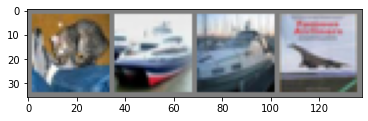

GroundTruth:  cat   ship  ship  plane
Predicted:  horse truck ship  plane


In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [13]:
correct = 0
total = 0
predicts = list()
all_labels = list()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = CNN(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicts.extend(predicted)
        all_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 83 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = CNN(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 82.4 %
Accuracy for class: automobile is 91.2 %
Accuracy for class: bird  is 74.2 %
Accuracy for class: cat   is 76.5 %
Accuracy for class: deer  is 81.1 %
Accuracy for class: dog   is 75.5 %
Accuracy for class: frog  is 87.7 %
Accuracy for class: horse is 87.7 %
Accuracy for class: ship  is 88.9 %
Accuracy for class: truck is 93.3 %


In [14]:
predicts = [i.item() for i in predicts]
all_labels = [i.item() for i in all_labels]

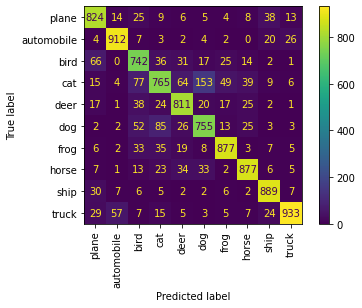

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predicts, all_labels)

ConfusionMatrixDisplay.from_predictions(predicts, all_labels, display_labels=classes, xticks_rotation='vertical')

In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
    
print(classification_report(predicts, all_labels, target_names=list(classes)))

              precision    recall  f1-score   support

       plane       0.82      0.87      0.85       946
  automobile       0.91      0.93      0.92       980
        bird       0.74      0.79      0.77       934
         cat       0.77      0.65      0.70      1181
        deer       0.81      0.85      0.83       956
         dog       0.76      0.78      0.77       966
        frog       0.88      0.88      0.88       995
       horse       0.88      0.88      0.88      1001
        ship       0.89      0.93      0.91       956
       truck       0.93      0.86      0.89      1085

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

